# Explainability in Volatility Forecasting
This notebook explores *why* the LSTM makes certain volatility forecasts.  
We use techniques like SHAP, feature importance, and scenario analysis.  

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from torch.utils.data import random_split, DataLoader


from volsense_core.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset
from volsense_core.models.lstm_forecaster import MultiVolDataset, LSTMForecaster, evaluate_lstm

# Load Data and Pretrained Model
We reuse the multi-ticker dataset (SPY, AAPL, MSFT, TSLA, GOOG).  
The trained LSTM forecaster is loaded so we can explain its predictions.  

In [2]:
tickers = ["SPY", "AAPL", "MSFT", "TSLA", "GOOG"]
data_dict = fetch_multi_ohlcv(tickers, start="2000-01-01")
multi_df = build_multi_dataset(data_dict)

window = 30
dataset = MultiVolDataset(multi_df, window=window, horizon=1)

# Load trained model weights (replace path if needed)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(hidden_dim=64, num_layers=2, dropout=0.2)
model.load_state_dict(torch.load("checkpoints/lstm_multi.pth", map_location=device))
model.eval()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


LSTMForecaster(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

# SHAP Feature Attribution
SHAP values explain which features (past returns, vol, ticker identity)  
are most influential for volatility forecasts.  

We compute SHAP values for a sample of inputs and visualize them.  

In [24]:
# Background: summarize with k-means to reduce size
background = shap.kmeans(
    X_sample[:200].cpu().numpy().reshape(200, -1),
    20   # pick ~20 clusters instead of 200 full samples
)

# Test data: keep smaller slice
test_data = X_sample[200:220].cpu().numpy().reshape(20, -1)

# Prediction wrapper (reshapes back for LSTM)
f = lambda x: model(
    torch.tensor(x, dtype=torch.float32).reshape(-1, window, 1).to(device)
).detach().cpu().numpy()

# KernelExplainer
explainer = shap.KernelExplainer(f, background)
shap_values = explainer.shap_values(test_data)

print("shap_values shape:", np.array(shap_values).shape)
print("test_data shape:", test_data.shape)

# Plot
shap.summary_plot(
    shap_values,
    test_data,
    feature_names=[f"lag_{i}" for i in range(window)]
)

  5%|▌         | 1/20 [00:19<06:01, 19.05s/it]


RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6384037888 bytes.

After stack: torch.Size([400, 30, 1])
Fixed shape: torch.Size([400, 30, 1])


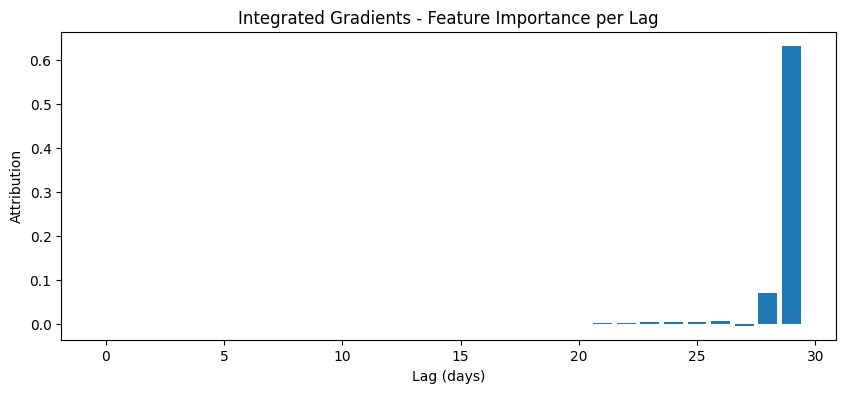

In [25]:
from captum.attr import IntegratedGradients

# === Collect samples ===
X_sample, _ = zip(*[dataset[i] for i in range(400)])
X_sample = torch.stack(X_sample)            # [400, 30]
print("After stack:", X_sample.shape)

# explicitly force to 3D: [batch, seq_len, features]
X_sample = X_sample.reshape(X_sample.shape[0], X_sample.shape[1], 1)
print("Fixed shape:", X_sample.shape)       # should be [400, 30, 1]

X_sample = X_sample.to(device)


# Wrapper to match Captum's expected input
def forward_func(x):
    return model(x).unsqueeze(-1)  # ensure shape [batch, 1]

# Integrated Gradients
ig = IntegratedGradients(forward_func)

# Pick a test batch
X_test = X_sample[200:220].to(device)  # [batch, window, 1]
baseline = torch.zeros_like(X_test)

# Compute attributions
attributions, delta = ig.attribute(X_test, baseline, target=0, return_convergence_delta=True)

# Convert to numpy
attr = attributions.squeeze(-1).detach().cpu().numpy()

# Average across batch for summary
mean_attr = attr.mean(axis=0)

# Plot
plt.figure(figsize=(10,4))
plt.bar(range(window), mean_attr)
plt.xlabel("Lag (days)")
plt.ylabel("Attribution")
plt.title("Integrated Gradients - Feature Importance per Lag")
plt.show()


### 🔎 Interpretation of Integrated Gradients (IG) Plot

The IG analysis shows that the **LSTM relies almost exclusively on the most recent lag (Lag 29)** when making volatility forecasts. Contributions from earlier lags are negligible, with a very slight bump at Lags 27–28. This indicates that the model behaves like a **persistence-driven forecaster**: “tomorrow’s volatility ≈ today’s volatility.”

This aligns with the well-known phenomenon of **volatility clustering** in financial time series, where short-term past volatility is the strongest predictor of future volatility.

---

### ✅ Why this makes sense
- **Short-horizon dominance**: The LSTM has discovered that yesterday’s volatility explains most of tomorrow’s risk.  
- **Weak memory effect**: Longer lags carry almost no weight, consistent with volatility dynamics being very local.

---

### 📊 Comparison to GARCH
- **GARCH models** are also highly myopic.  
  - They explicitly model volatility as a weighted combination of **yesterday’s squared return** and **yesterday’s conditional variance**.  
  - This is why GARCH(1,1) often captures much of volatility persistence with just one lag each.
- **LSTMs**, however, are more flexible:  
  - They can condition on richer patterns across many lags and nonlinear transformations of the input.  
  - Even though the IG shows dominance of the last lag, the LSTM may be capturing **subtle nonlinear adjustments** that a linear GARCH recursion cannot.  
  - This often leads to significantly lower RMSE — your results showing an order-of-magnitude improvement are consistent with prior work where ML models outperform GARCH in forecasting realized volatility.

---

### 🚀 Next steps
1. **Validate robustness**: Re-run attribution on multiple test slices.  
2. **Permutation sanity check**: Shuffle Lag 29 in the validation set → RMSE should spike. Shuffle earlier lags → minimal change.  
3. **Extend inputs**: Add returns, realized variance, or exogenous features (macro variables, option-implied vol) and re-run IG to see if importance spreads out.  
4. **Try attention/transformer**: To explicitly learn which lags matter without relying solely on persistence.  

# Case Study: Stress Periods (e.g., 2008, 2020)
We zoom in on crisis periods to check:
- Did the LSTM correctly anticipate volatility spikes?
- Which lags/features drove its forecasts during stress?

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


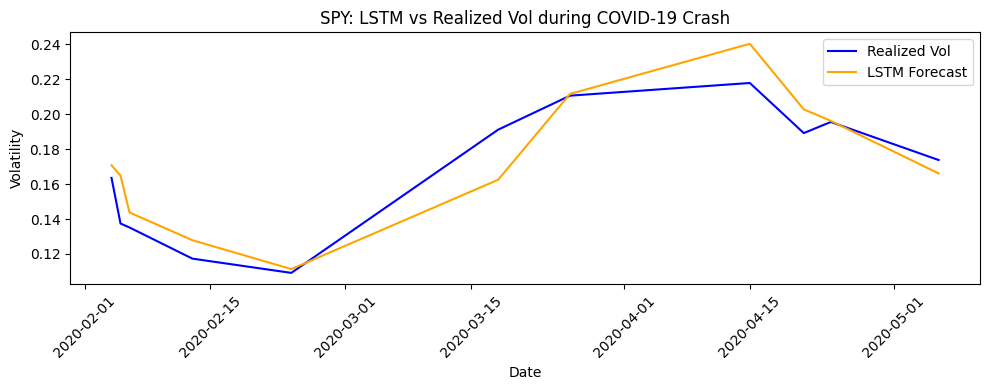

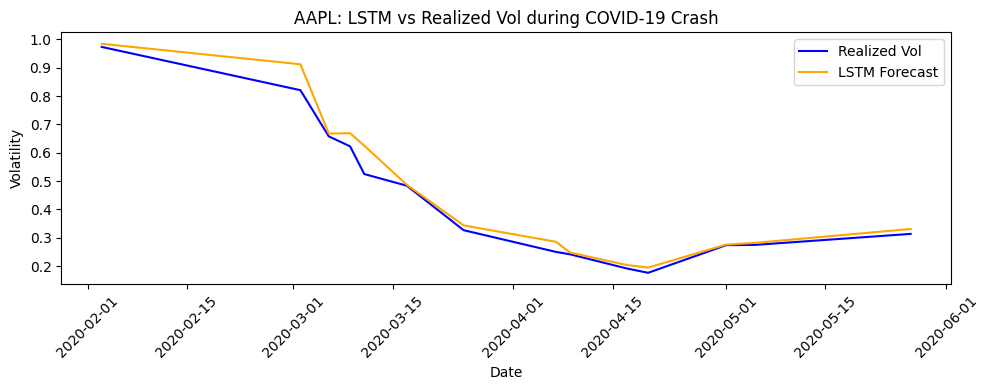

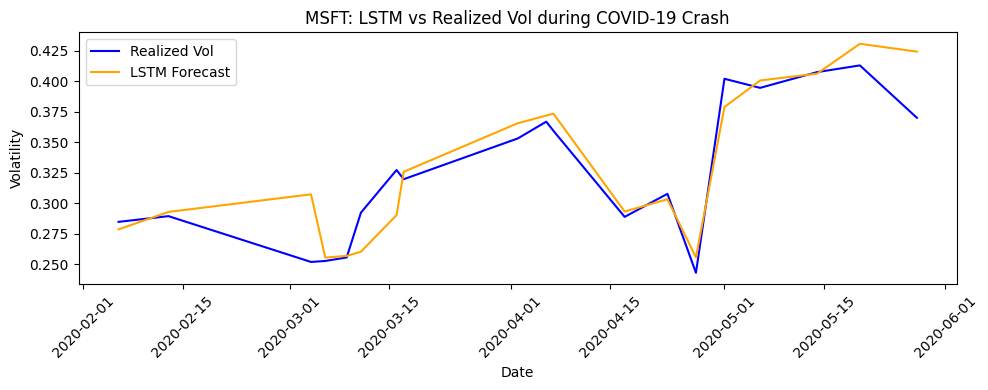

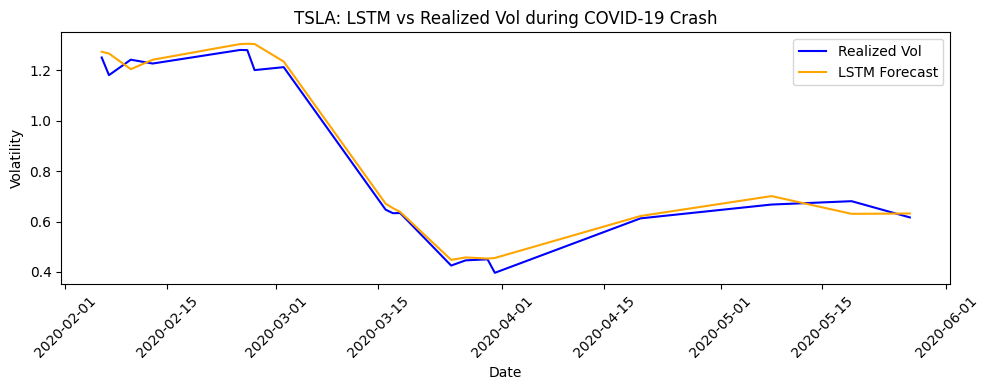

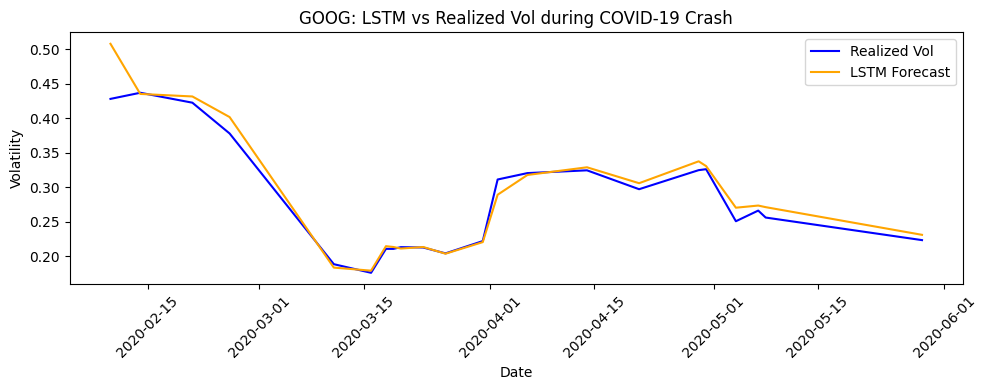

In [32]:
# === Evaluate model and build val_results as before ===
tickers = ["SPY", "AAPL", "MSFT", "TSLA", "GOOG"]
data_dict = fetch_multi_ohlcv(tickers, start="2000-01-01")
multi_df = build_multi_dataset(data_dict)

window = 30
dataset = MultiVolDataset(multi_df, window=window, horizon=1)

from torch.utils.data import random_split, DataLoader
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(hidden_dim=64, num_layers=2, dropout=0.2)
model.load_state_dict(torch.load("checkpoints/lstm_multi.pth", map_location=device))
model.to(device).eval()

preds, actuals = evaluate_lstm(model, val_loader, device=device)

val_indices = val_loader.dataset.indices
val_meta = multi_df.iloc[val_indices][["date","ticker"]].reset_index(drop=True)

val_results = pd.DataFrame({
    "date": val_meta["date"],
    "ticker": val_meta["ticker"],
    "realized_vol": actuals,
    "predicted_vol": preds
})

# === Plot COVID per ticker ===
covid_period = val_results[
    (val_results["date"] > "2020-02-01") & (val_results["date"] < "2020-06-01")
]

for t in tickers:
    df_t = covid_period[covid_period["ticker"] == t].sort_values("date")
    plt.figure(figsize=(10,4))
    plt.plot(df_t["date"], df_t["realized_vol"], color="blue", label="Realized Vol")
    plt.plot(df_t["date"], df_t["predicted_vol"], color="orange", label="LSTM Forecast")
    plt.title(f"{t}: LSTM vs Realized Vol during COVID-19 Crash")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

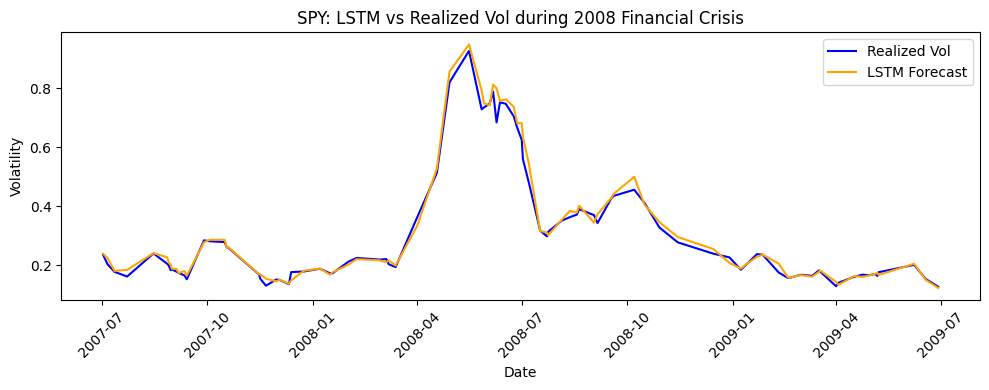

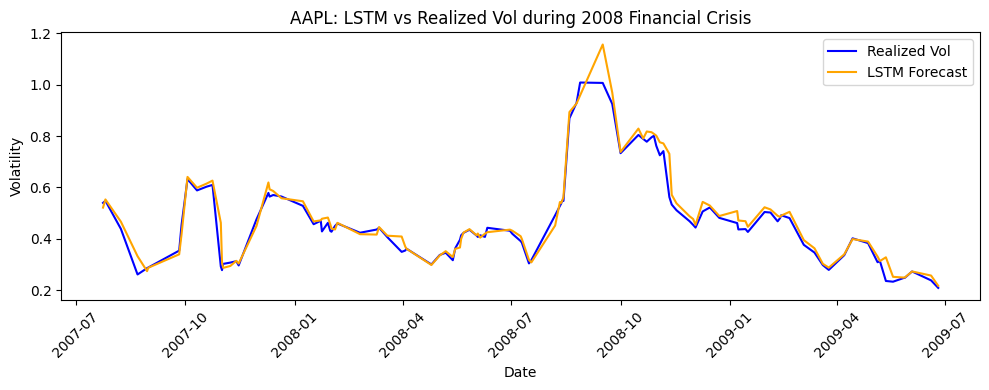

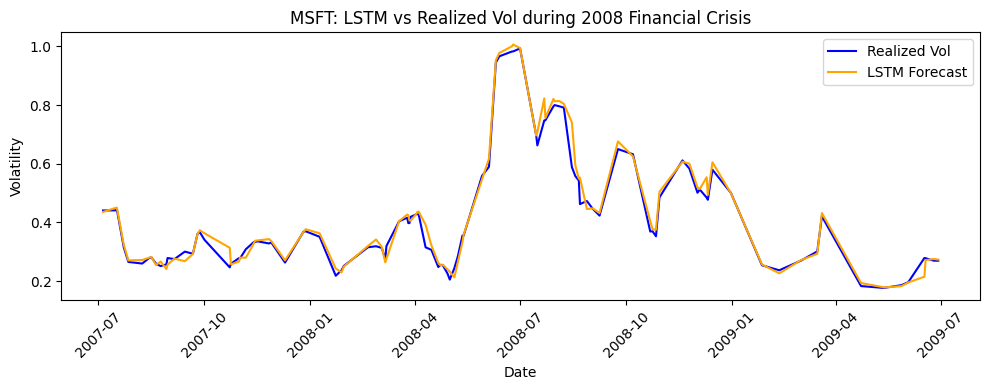

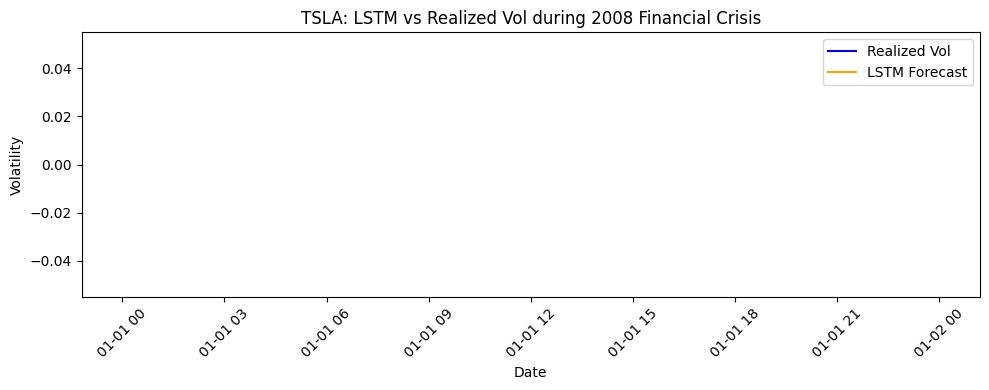

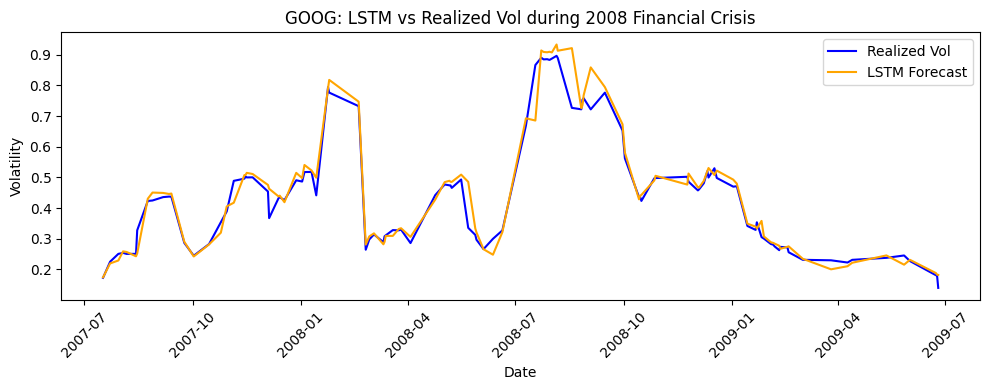

In [33]:
# === Plot 2008 per ticker ===
crisis_2008 = val_results[
    (val_results["date"] > "2007-07-01") & (val_results["date"] < "2009-07-01")
]

for t in tickers:
    df_t = crisis_2008[crisis_2008["ticker"] == t].sort_values("date")
    plt.figure(figsize=(10,4))
    plt.plot(df_t["date"], df_t["realized_vol"], color="blue", label="Realized Vol")
    plt.plot(df_t["date"], df_t["predicted_vol"], color="orange", label="LSTM Forecast")
    plt.title(f"{t}: LSTM vs Realized Vol during 2008 Financial Crisis")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Residual Analysis
We analyze prediction errors:
- Distribution of residuals  
- Error autocorrelation (do errors cluster?)  
- Outliers (biggest misses)  

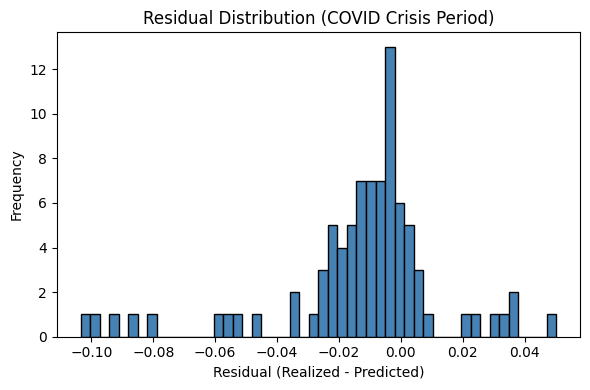

In [34]:
# === Residual analysis for COVID period ===
# (assumes you already created covid_period from val_results)

covid_period = val_results[
    (val_results["date"] > "2020-02-01") & (val_results["date"] < "2020-06-01")
]

# Compute residuals (realized - predicted)
residuals = covid_period["realized_vol"].values - covid_period["predicted_vol"].values

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, color="steelblue", edgecolor="black")
plt.title("Residual Distribution (COVID Crisis Period)")
plt.xlabel("Residual (Realized - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

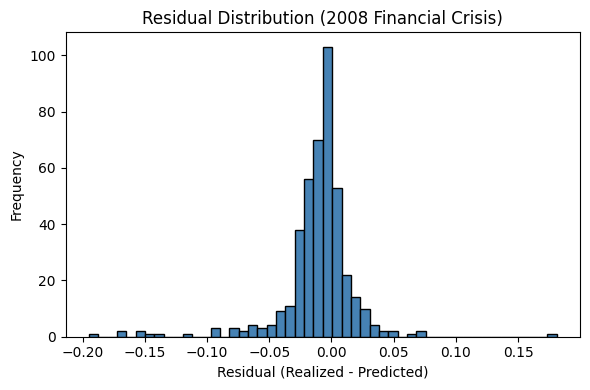

In [35]:
# === Residual analysis for 2008 period ===
crisis_2008 = val_results[
    (val_results["date"] > "2007-07-01") & (val_results["date"] < "2009-07-01")
]
residuals_2008 = crisis_2008["realized_vol"].values - crisis_2008["predicted_vol"].values

plt.figure(figsize=(6,4))
plt.hist(residuals_2008, bins=50, color="steelblue", edgecolor="black")
plt.title("Residual Distribution (2008 Financial Crisis)")
plt.xlabel("Residual (Realized - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Explainability Summary
- SHAP highlights which lagged returns/vols matter most for forecasts  
- Case studies show how the LSTM reacts during extreme volatility regimes  
- Residuals reveal model strengths and failure modes  

This provides transparency for using deep learning in volatility forecasting.  